### For this project, we will be scraping data from GitHub repository README files. The goal will be to build a model that can predict what programming language a repository is, given the text of the README file.

#### Deliverables

1. A well-documented jupyter notebook that contains your analysis
2. Three or four google slides suitable for a general audience that summarize your findings. Include a well-labelled visualization in your slides.

In [3]:
from requests import get
from bs4 import BeautifulSoup
import os
import re
from env import github_token, github_username
import scraper2
import model
import pandas as pd
import json
import seaborn as sns
import time
import prepare_r
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from scipy import stats
import acquire2

plt.rc('figure', figsize=(10, 6))
plt.rc('font', size=14)
plt.style.use('seaborn-darkgrid')

### Data Acquisition:
1. Acquire list of repos we want to analyze using the scraper.py
2. Use acquire.py (Zach's code) to scrape readme files from Github

In [15]:
# List of urls for github
g_url = ['https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories', ' https://github.com/search?p=2&q=stars%3A%3E0&s=stars&type=Repositories'\
         'https://github.com/search?p=3&q=stars%3A%3E0&s=stars&type=Repositories', 'https://github.com/search?p=4&q=stars%3A%3E0&s=stars&type=Repositories',\
         'https://github.com/search?p=5&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=6&q=stars%3A%3E0&s=stars&type=Repositories',\
        'https://github.com/search?p=7&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=8&q=stars%3A%3E0&s=stars&type=Repositories',\
        'https://github.com/search?p=9&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=10&q=stars%3A%3E0&s=stars&type=Repositories',
        'https://github.com/search?p=11&q=stars%3A%3E0&s=stars&type=Repositories', 'https://github.com/search?p=12&q=stars%3A%3E0&s=stars&type=Repositories',
        'https://github.com/search?p=13&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=14&q=stars%3A%3E0&s=stars&type=Repositories',
        'https://github.com/search?p=15&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=16&q=stars%3A%3E0&s=stars&type=Repositories',
        'https://github.com/search?p=17&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=18&q=stars%3A%3E0&s=stars&type=Repositories',
        'https://github.com/search?p=19&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=20&q=stars%3A%3E0&s=stars&type=Repositories',
        'https://github.com/search?p=21&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=22&q=stars%3A%3E0&s=stars&type=Repositories',
        'https://github.com/search?p=23&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=24&q=stars%3A%3E0&s=stars&type=Repositories',
        'https://github.com/search?p=25&q=stars%3A%3E0&s=stars&type=Repositories','https://github.com/search?p=26&q=stars%3A%3E0&s=stars&type=Repositories']

In [3]:
# g_url = ['https://github.com/search?o=desc&q=stars:%3E1&s=forks&type=Repositories']

In [16]:
# Scrape the name of github repos
repo_list = scraper2.get_repos(g_url)

In [18]:
#total number of repos scraped
len(repo_list)

250

In [19]:
# first five repos
repo_list [0:5]

['/freeCodeCamp/freeCodeCamp',
 '/996icu/996.ICU',
 '/vuejs/vue',
 '/EbookFoundation/free-programming-books',
 '/facebook/react']

In [20]:
# use regex to remove first slash from repo names
list1 = []
for repo in repo_list:
    repo1 = re.search(r'[a-z0-9A-Z].+', repo)[0]
    list1.append(repo1)
    

In [21]:
# Look at first five repo names
list1[0:5]

['freeCodeCamp/freeCodeCamp',
 '996icu/996.ICU',
 'vuejs/vue',
 'EbookFoundation/free-programming-books',
 'facebook/react']

In [1]:
list1[0:5]

NameError: name 'list1' is not defined

In [26]:
# The acquired data is read from data2.json and store in a dataframe 'df'
f = open('data3.json')
json_file = json.load(f)

df = pd.DataFrame(json_file)

In [27]:
df.head()

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...
2,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
3,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             250 non-null    object
 1   language         212 non-null    object
 2   readme_contents  250 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB


In [29]:
# look at repos where language is 'None'
df[df.language.isnull()].head(5)

,repo,language,readme_contents
3,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...
6,sindresorhus/awesome,None,"<div align=""center"">\n\t<img width=""500"" heigh..."
8,jwasham/coding-interview-university,None,# Coding Interview University\n\n> I originall...
9,kamranahmedse/developer-roadmap,None,\n![Web Developer Roadmap - 2020](https://i.im...
10,getify/You-Dont-Know-JS,None,# You Don't Know JS Yet (book series) - 2nd Ed...


In [30]:
df.language.value_counts()

JavaScript          74
Python              28
Java                17
Go                  16
TypeScript          16
C++                 12
C                    7
Ruby                 5
CSS                  5
Shell                4
HTML                 4
Swift                3
Vue                  3
Dart                 2
Dockerfile           2
Kotlin               2
Rust                 2
PHP                  2
TeX                  1
Objective-C          1
C#                   1
Clojure              1
Jupyter Notebook     1
SCSS                 1
Vim script           1
Assembly             1
Name: language, dtype: int64

In [31]:
df = df.groupby('language').filter(lambda x: len(x)>7)

In [32]:
df.head()

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
2,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...
5,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www...."
7,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://v5.getb..."


In [33]:
df.language.value_counts()

JavaScript    74
Python        28
Java          17
Go            16
TypeScript    16
C++           12
Name: language, dtype: int64

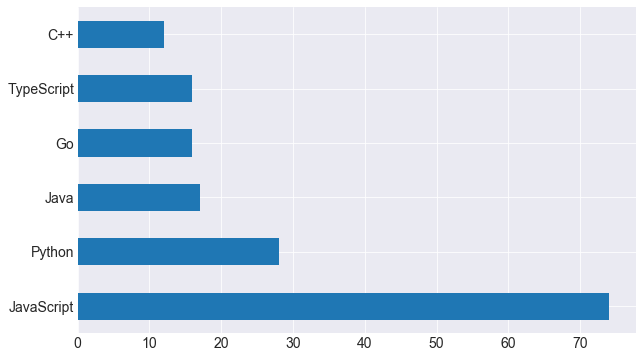

In [34]:
df.language.value_counts().plot.barh()

In [35]:
df = df.drop(columns = ['repo'])

In [36]:
# We next call a function named 'prep_contents' from prepare.py
df = prepare_r.prep_contents(df)

In [37]:
df.head()

,language,readme_contents,original,normalized,stemmed,lemmatized,cleaned
0,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp org social banner https amaz...,freecodecamp org social banner http amazonaw c...,freecodecamp org social banner http amazonaws ...,freecodecamp org social banner amazonaws com f...
2,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...","<p align=""center""><a href=""https://vuejs.org"" ...",align center href https vuejs org targ...,align center href http vuej org target blank r...,align center href http vuejs org target blank ...,align center href vuejs org target blank rel n...
4,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,# [React](https://reactjs.org/) &middot; [![Gi...,react https reactjs org middot githu...,react http reactj org middot github licens htt...,react http reactjs org middot github license h...,react reactjs org middot license img shield ba...
5,C++,"<div align=""center"">\n <img src=""https://www....","<div align=""center"">\n <img src=""https://www....",div align center img src https www te...,div align center img src http www tensorflow o...,div align center img src http www tensorflow o...,div align center img src tensorflow org image ...
7,JavaScript,"<p align=""center"">\n <a href=""https://v5.getb...","<p align=""center"">\n <a href=""https://v5.getb...",align center href https getbootstr...,align center href http getbootstrap com img sr...,align center href http getbootstrap com img sr...,align center href getbootstrap com img src get...


In [38]:
df = df.drop(columns = ['original', 'normalized', 'stemmed', 'lemmatized'])
df = df.reset_index(drop = True)

In [39]:
df.head(3)

,language,readme_contents,cleaned
0,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp org social banner amazonaws com f...
1,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...",align center href vuejs org target blank rel n...
2,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,react reactjs org middot license img shield ba...


In [43]:
# Train test split before exploration

train, test = train_test_split(df, train_size = 0.8, random_state = 123, stratify = df.language)

In [44]:
train.head()

,language,readme_contents,cleaned
0,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp org social banner amazonaws com f...
104,Java,Retrofit\n========\n\nA type-safe HTTP client ...,retrofit type safe client android java informa...
20,TypeScript,\r\n# TypeScript\r\n\r\n[![Build Status](https...,typescript build status travis org microsoft t...
111,Go,"# <img src=""https://github.com/gogs/gogs/raw/m...",img src com gogs gogs raw main public img favi...
158,Python,### 12306 购票小助手\n#### python版本\n - [ ] 2.7.10...,python server com zhaipro easy pan baidu com v...


In [46]:
# check the shape of train and test dataframes
train.shape, test.shape

((130, 3), (33, 3))

In [57]:
word_counts = pd.Series((' '.join(train.cleaned)).split()).value_counts()
word_counts

com        11229
react       3197
native      3058
org         1737
img         1710
           ...  
awslabs        1
habito         1
keane          1
ewald          1
kieffer        1
Length: 22410, dtype: int64

Text(0.5, 1.0, '15 most common words in all repos')

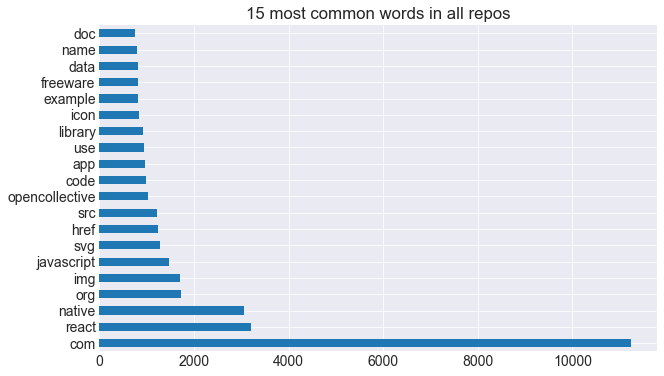

In [64]:
plt.figure(figsize = (10,6))
word_counts.head(20).plot.barh()
plt.title('15 most common words in all repos')

In [66]:
train.head()

,language,readme_contents,cleaned
0,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp org social banner amazonaws com f...
104,Java,Retrofit\n========\n\nA type-safe HTTP client ...,retrofit type safe client android java informa...
20,TypeScript,\r\n# TypeScript\r\n\r\n[![Build Status](https...,typescript build status travis org microsoft t...
111,Go,"# <img src=""https://github.com/gogs/gogs/raw/m...",img src com gogs gogs raw main public img favi...
158,Python,### 12306 购票小助手\n#### python版本\n - [ ] 2.7.10...,python server com zhaipro easy pan baidu com v...


In [70]:
len(train.cleaned[0].split())

1774

In [72]:
train['repo_lenght'] = train.cleaned.apply(lambda x: len(x.split()))

In [73]:
train.head()

,language,readme_contents,cleaned,repo_lenght
0,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp org social banner amazonaws com f...,1774
104,Java,Retrofit\n========\n\nA type-safe HTTP client ...,retrofit type safe client android java informa...,159
20,TypeScript,\r\n# TypeScript\r\n\r\n[![Build Status](https...,typescript build status travis org microsoft t...,487
111,Go,"# <img src=""https://github.com/gogs/gogs/raw/m...",img src com gogs gogs raw main public img favi...,652
158,Python,### 12306 购票小助手\n#### python版本\n - [ ] 2.7.10...,python server com zhaipro easy pan baidu com v...,161


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

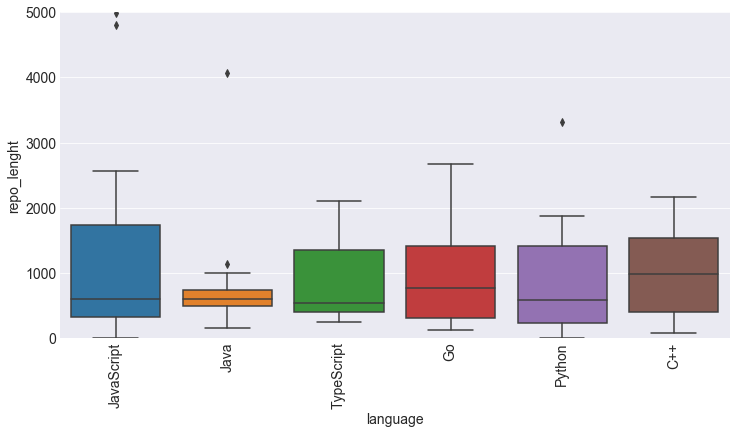

In [78]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'repo_lenght', data = train)
plt.ylim(0,5000)
plt.xticks(rotation = 90)